In [1]:
#Imports
from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.all import *

## Data and dataloader preparation

In [48]:
data_path = untar_data(URLs.PETS)
print(data_path)

/home/jan/.fastai/data/oxford-iiit-pet


In [3]:
#Set the seed for reproducibility
np.random.seed(42)

In [49]:
#See the dataset structure
data_path.ls()[:3]

(#2) [Path('/home/jan/.fastai/data/oxford-iiit-pet/annotations'),Path('/home/jan/.fastai/data/oxford-iiit-pet/images')]

Build `DataLoader` directly - highest level of FastAI API

In [44]:
filenames = get_image_files(data_path/ 'images')

In [47]:
L(data_path/'images')

(#1) [Path('/home/jan/.fastai/data/food-101/images')]

In [5]:
#Get the filenames and build the pattern to extract class from them
filenames = get_image_files(data_path/ 'images')
regx_pattern = r'(.+)_\d+.jpg$'

#Define some Image and Batch level transformations
item_tfms = RandomResizedCrop(460, min_scale =0.8, ratio = (1.,1.))
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
batch_size = 32 

#Build databunch
dataloader1 = ImageDataLoaders.from_name_re(data_path, filenames, regx_pattern, batch_tfms=batch_tfms, item_tfms = item_tfms, bs = batch_size)

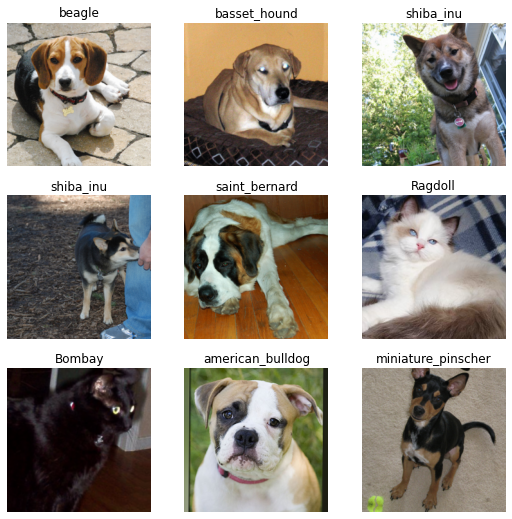

In [6]:
dataloader1.show_batch()

Alternatively, build `DataBlock` first (mid-level API) and then use it to generate `DataLoader`

In [7]:
# Define Datablock with (input,output) in blocks
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=RegexLabeller(pat = r'/([^/]+)_\d+.*'),
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)

In [8]:
image_path = data_path/'images'

In [9]:
#Build dataloaders
dataloaders2 = pets.dataloaders(image_path, bs=batch_size)

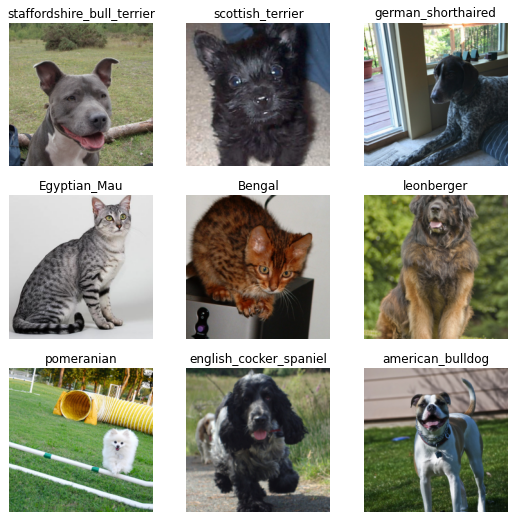

In [10]:
dataloaders2.show_batch()

One can also look at all the classes and their corresponding labels

In [11]:
dataloaders2.vocab.o2i

{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British_Shorthair': 4,
 'Egyptian_Mau': 5,
 'Maine_Coon': 6,
 'Persian': 7,
 'Ragdoll': 8,
 'Russian_Blue': 9,
 'Siamese': 10,
 'Sphynx': 11,
 'american_bulldog': 12,
 'american_pit_bull_terrier': 13,
 'basset_hound': 14,
 'beagle': 15,
 'boxer': 16,
 'chihuahua': 17,
 'english_cocker_spaniel': 18,
 'english_setter': 19,
 'german_shorthaired': 20,
 'great_pyrenees': 21,
 'havanese': 22,
 'japanese_chin': 23,
 'keeshond': 24,
 'leonberger': 25,
 'miniature_pinscher': 26,
 'newfoundland': 27,
 'pomeranian': 28,
 'pug': 29,
 'saint_bernard': 30,
 'samoyed': 31,
 'scottish_terrier': 32,
 'shiba_inu': 33,
 'staffordshire_bull_terrier': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

## Easiest classifier training

Create the simplest Learner (model+ training pipeline):
* pass the `Dataloaders`
* choose the model architecture
* choose the metrics to see how well model is performing
* choose loss function (so that model knows how to improve, default ` CrossEntropyFlat` in that case)
* choose optimizer (to tell the model how to adjust itself at each step, default `Adam` here)

In [22]:
learner = cnn_learner(dataloaders2, resnet50, pretrained=True, metrics=error_rate).to_fp16()

And train:

In [23]:
learner.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.814205,0.348960,0.107578,00:24
1,0.436145,0.271164,0.081867,00:24
2,0.304890,0.262916,0.081191,00:24
3,0.195200,0.220191,0.069012,00:24
4,0.137224,0.209158,0.065629,00:24


In [24]:
learner.save('base_pet_classifier')

Path('models/base_pet_classifier.pth')

## Interpreting results

Using the interpration module and making sure we have all the validation scores/data aligned

In [25]:
interp = ClassificationInterpretation.from_learner(learner)
losses,idxs = interp.top_losses()

len(dataloaders2.valid_ds)==len(losses)==len(idxs)

True

Plot where the model was most wrong

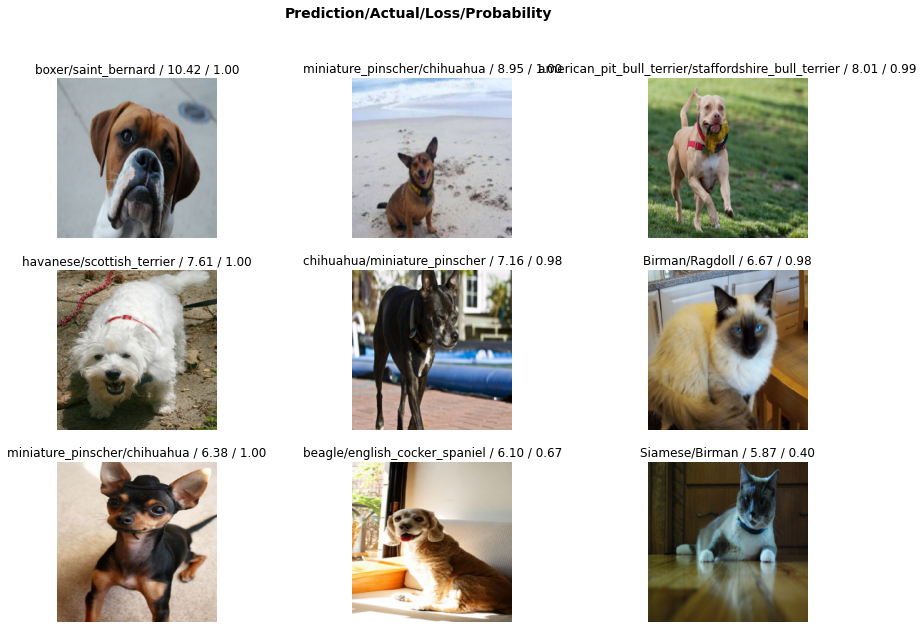

In [26]:
interp.plot_top_losses(9, figsize=(15,10))

Confusion Matrix will help too

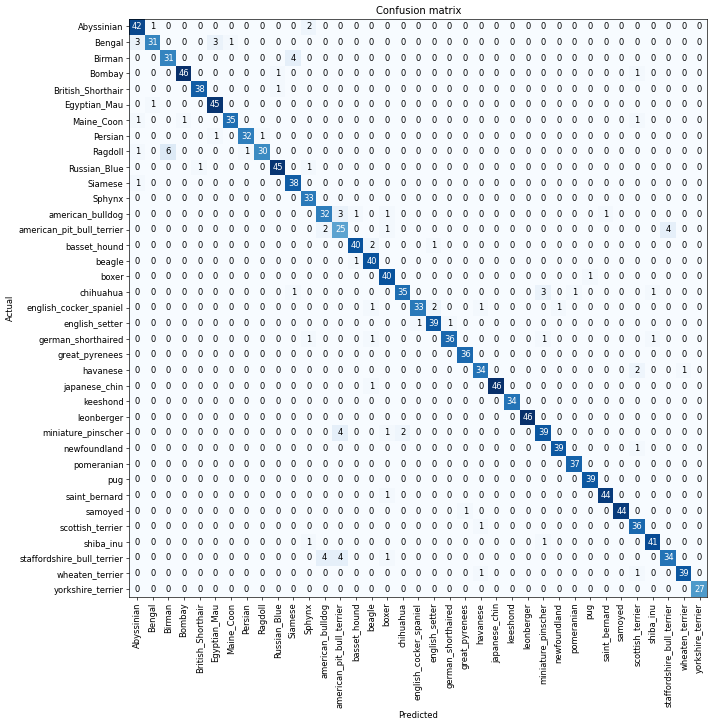

In [27]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

## Tuning the model a bit (prone to overfitting at the moment)

In [28]:
#Load the base model
learner.load('base_pet_classifier')

In [29]:
#Now the pretrained weights will change too, not only model head
learner.unfreeze()

In [30]:
learner.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.251119,4.837820,0.796346,00:30
1,1.424189,1.237441,0.382273,00:30
2,0.777452,0.589305,0.192152,00:30
3,0.363433,0.474121,0.156292,00:31


It seems that the Learning Rate is too high when all model layers are unlocked and the gradients fly all over the place - model performance drops

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=2.2908675418875646e-06)

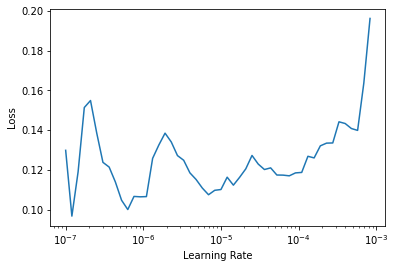

In [33]:
# Let's load it again, unfreeze and find a good learning rate
learner.load('base_pet_classifier')

learner.lr_find()

The LR between 1e-6 to 1e-4 seems good, we can actually set it as a slice so that deeper (earlier) layers in the model get adjusted less (they are already good at what they do)

In [34]:
learner.unfreeze()
learner.fit_one_cycle(4, lr_max=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.120696,0.221037,0.067659,00:31
1,0.109371,0.207672,0.066982,00:31
2,0.099056,0.212229,0.062246,00:30
3,0.068575,0.209082,0.061570,00:30


In [35]:
learner.save('tuned_pet_classifier')

Path('models/tuned_pet_classifier.pth')

Metrics have improved slightly, we can interpret it again. The easiest way to push the performance further would be to use larger model (ResNet50 for example).

In [36]:
interp = ClassificationInterpretation.from_learner(learner)
losses,idxs = interp.top_losses()

len(dataloaders2.valid_ds)==len(losses)==len(idxs)

True

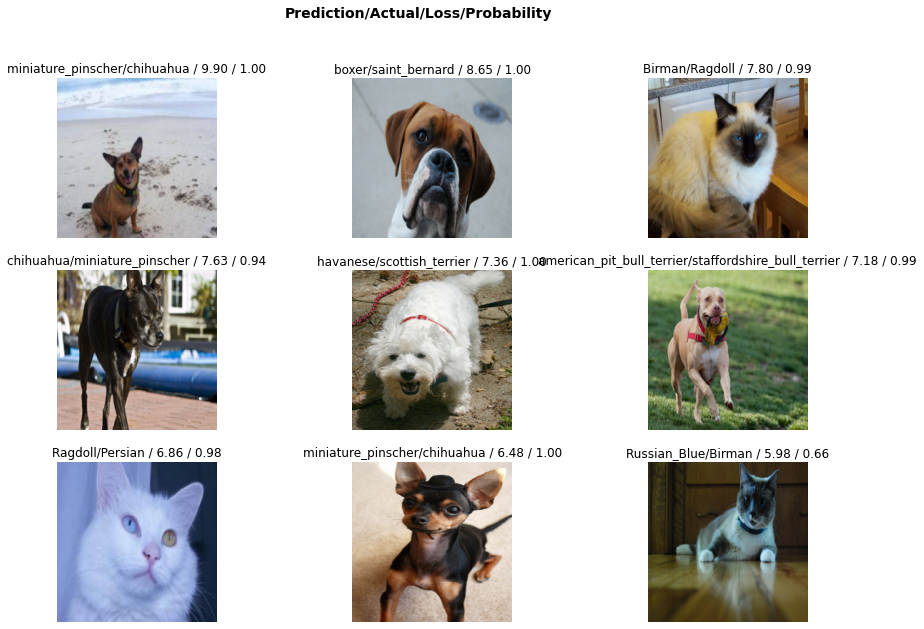

In [37]:
interp.plot_top_losses(9, figsize=(15,10))

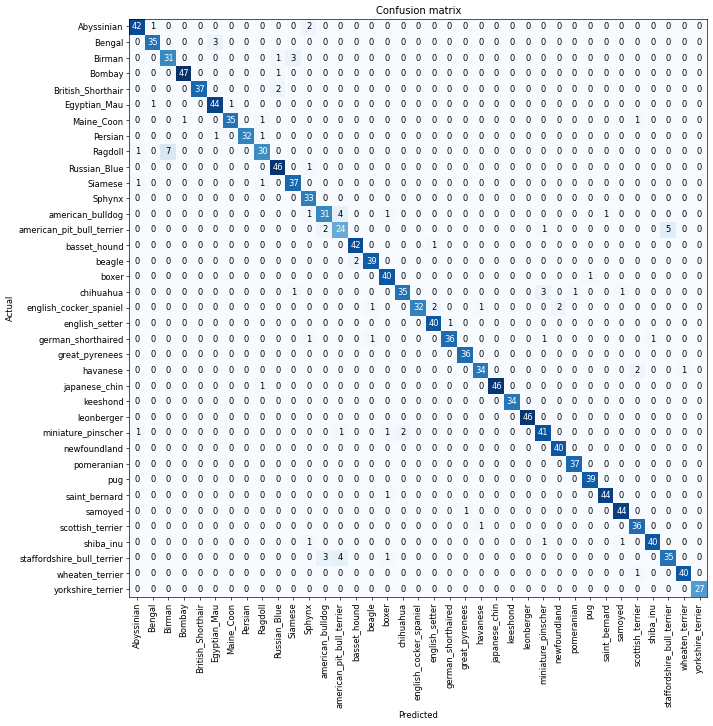

In [38]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

Even the tuned model, still fails on the same images. Larger model might help, but cleaning/enlarging the dataset a bit would probably help too. It is also worth noting that despite overall decrease of error rate, in some specific cases error is larger now (Ragdoll/Birman case)